In [ ]:
# Description: This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM)
#              to predict the closing stock price of a corporation (Alphabet Inc Class A) using the 90 day stock price.

In [1]:
# Import the Libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

Using TensorFlow backend.


In [45]:
# Get stock quote
df =web.DataReader("GOOGL", data_source="yahoo", start="2010-01-01", end="2019-12-01")

#show the data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,313.013000,310.300293,312.687683,310.300293,2437100.0,310.300293
2010-01-04,315.070068,312.432434,313.788788,313.688690,3908400.0,313.688690
2010-01-05,314.234222,311.081085,313.903900,312.307312,6003300.0,312.307312
2010-01-06,313.243256,303.483490,313.243256,304.434448,7949400.0,304.434448
2010-01-07,305.305298,296.621613,305.005005,297.347351,12815700.0,297.347351
...,...,...,...,...,...,...
2019-11-22,1306.900024,1289.359985,1303.000000,1293.670044,1388800.0,1293.670044
2019-11-25,1310.410034,1295.609985,1296.260010,1305.640015,1179500.0,1305.640015
2019-11-26,1314.010010,1304.040039,1309.910034,1313.000000,1095500.0,1313.000000


In [46]:
# Get the number of rows and columns in the dataset
df.shape

(2496, 6)

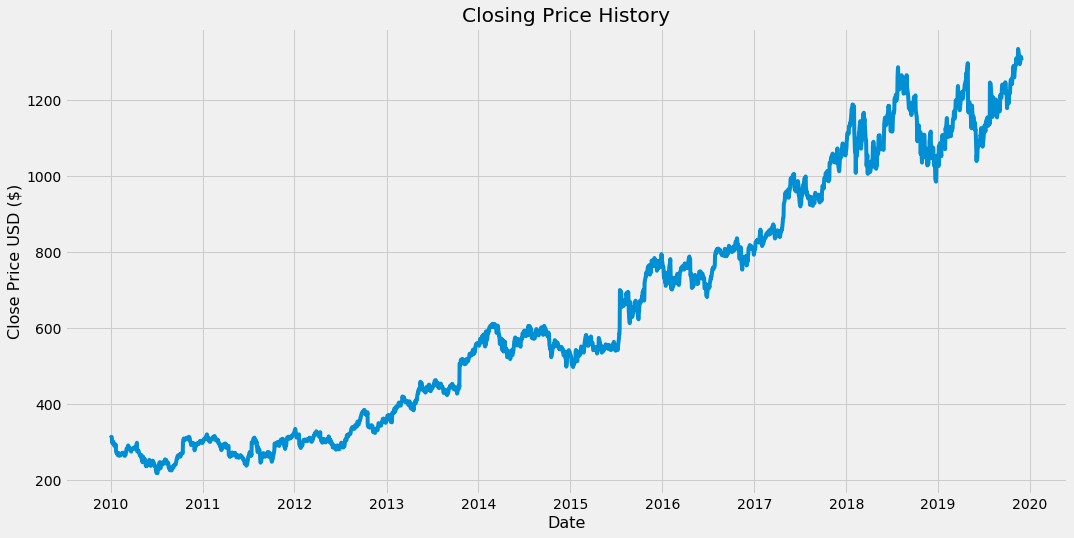

In [47]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title("Closing Price History")
plt.plot(df["Close"])
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price USD ($)', fontsize=16)
plt.show()

In [48]:
# Create a new dataframe of "Close" Column
data = df.filter(['Close'])

# Convert dataframe to numpy array
dataset = data.values

# Get train rows for model
data_train_len = math.ceil(len(dataset) * 0.8)
data_train_len

1997

In [49]:
# Data Preprocessing / Scaling
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.08253217],
       [0.08557031],
       [0.08433173],
       ...,
       [0.98158318],
       [0.98080311],
       [0.97359417]])

In [50]:
# Create trainign dataset
training_data = scaled_data[0:data_train_len,:]

# Split x_train & y_train
x_train = []
y_train = []
for i in range(90, len(training_data)):
    x_train.append(training_data[i-90:i, 0])
    y_train.append(training_data[i,0])

In [51]:
# Create testing dataset
testing_data = scaled_data[data_train_len-90:, :]

# Split to x_test & y_test
x_test = []
y_test = dataset[data_train_len:, :]
for i in range(90, len(testing_data)):
    x_test.append(testing_data[i-90:i, 0]) 

In [52]:
# Convert training & testing sets to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_test = np.array(x_test)

In [53]:
# Reshape the x_train Dataset (LSTM expects data in 3D - No. os sample, timesteps and features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1907, 90, 1)

In [54]:
# Reshape the x_test Dataset (To match training set and test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(499, 90, 1)

In [55]:
# Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [56]:
# Model Compilation & Optimization
# Optimizer is used to improve upon the loss function
# Loss function is used to measure how well the model performed oon training
model.compile(optimizer='adam', loss="mean_squared_error")

In [58]:
# Training the model
model.fit(x_train, y_train, batch_size=5, epochs=5)

Epoch 1/5
1907/1907 [==============================] - 188s 99ms/step - loss: 0.0027
Epoch 2/5
1907/1907 [==============================] - 180s 94ms/step - loss: 3.0195e-04
Epoch 3/5
1907/1907 [==============================] - 195s 102ms/step - loss: 3.1450e-04
Epoch 4/5
1907/1907 [==============================] - 215s 113ms/step - loss: 2.2385e-04
Epoch 5/5
1907/1907 [==============================] - 229s 120ms/step - loss: 2.4986e-04


In [61]:
# Get the model's prediction
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


In [62]:
# Get the RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
rmse

30.711935764719012

C:\Users\PKG\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


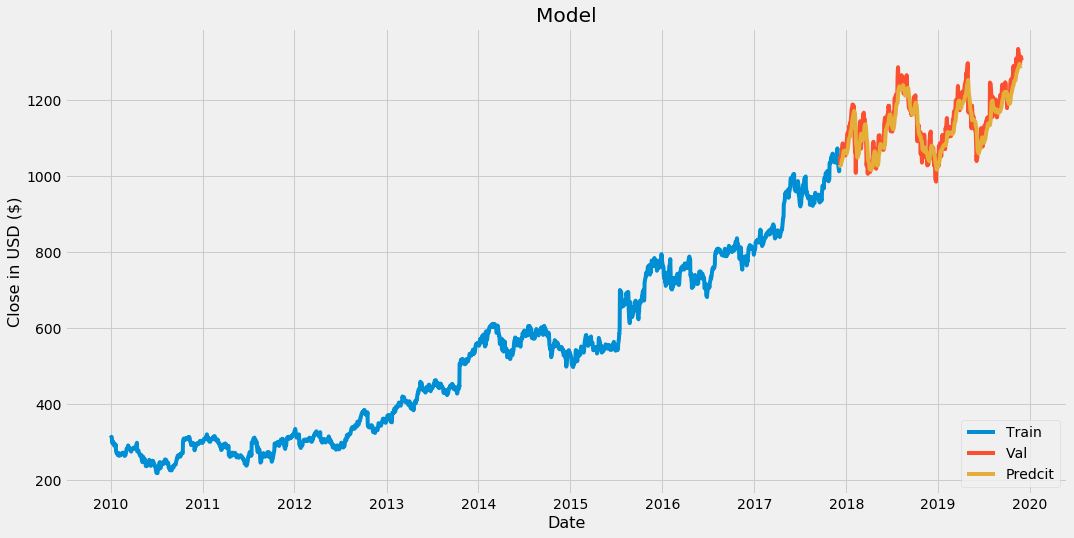

In [63]:
# Plot the data
train_data = data[0:data_train_len]
validation_data = data[data_train_len:]
validation_data['Prediction'] = predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date", fontsize = 16)
plt.ylabel("Close in USD ($)", fontsize = 16)
plt.plot(train_data['Close'])
plt.plot(validation_data[['Close', 'Prediction']])
plt.legend(['Train', 'Val', 'Predcit'], loc="lower right")

In [64]:
# Show the valid & predicted price
validation_data

,Close,Prediction
Date,,
2017-12-06,1032.719971,1029.539551
2017-12-07,1044.569946,1026.269653
2017-12-08,1049.380005,1026.098999
2017-12-11,1051.969971,1028.130493
2017-12-12,1048.770020,1031.400391
...,...,...
2019-11-22,1293.670044,1292.526123
2019-11-25,1305.640015,1289.669556
2019-11-26,1313.000000,1287.979370


In [65]:
# Get the quote
google_quote = web.DataReader('GOOGL', data_source='yahoo', start="2010-01-03", end="2020-01-03")
#Create a new dataframe
new_df = google_quote.filter(['Close'])
# Get last 90 days data
last_90_days = new_df[-90:].values
#Scale the new values between 0 and 1
last_90_days_scaled = scaler.transform(last_90_days)
# Create list and append for testing
X_test = []
X_test.append(last_90_days_scaled)
# Convert test data in numpy array
X_test = np.array(X_test)
# Reshape the data to 3D
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get predicted scaled price
predicted_price = model.predict(X_test)
# Inverse scleing
predicted_price = scaler.inverse_transform(predicted_price)
# PRint the predicted price
print(predicted_price)

[[1331.4246]]


In [66]:
google_quote = web.DataReader('GOOGL', data_source='yahoo', start="2020-01-03", end="2020-01-03")
print(google_quote['Close'])

Date
2020-01-02    1368.680054
2020-01-03    1361.520020
Name: Close, dtype: float64
